In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, f1_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

In [5]:
# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
path = "C:/Users/viczh/elliptic-data-set/elliptic_bitcoin_dataset/"

features = pd.read_csv(path + "elliptic_txs_features.csv", header=None)
classes  = pd.read_csv(path + "elliptic_txs_classes.csv")

# Name columns
colnames = ["txId", "timestep"] + [f"f_{i}" for i in range(165)]
features.columns = colnames

# ---------------------------------------------------------
# 2. MERGE LABELS AND REMOVE UNKNOWN NODES
# ---------------------------------------------------------
df = features.merge(classes, on="txId", how="left")
df = df[df["class"] != "unknown"]      # supervised model → must remove unknown
df = df.drop(columns=["txId"])

# Map labels: illicit=1, licit=0
label_map = {"1": 1, "2": 0}
df["class"] = df["class"].map(label_map)

# ---------------------------------------------------------
# 3. TEMPORAL SPLIT
# ---------------------------------------------------------
train_df = df[df["timestep"] < 35]
val_df   = df[(df["timestep"] >= 35) & (df["timestep"] < 42)]
test_df  = df[df["timestep"] >= 42]

# Combine train + val for RF (validation optional)
train_val_df = pd.concat([train_df, val_df], ignore_index=True)

X_train = train_val_df.drop(columns=["class"])
y_train = train_val_df["class"]

X_test = test_df.drop(columns=["class"])
y_test = test_df["class"]

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("Illicit proportion in train:", y_train.mean())
print("Illicit proportion in test:", y_test.mean())


Train size: 37723
Test size: 8841
Illicit % in train: 0.10966784190016701
Illicit % in test: 0.04614862572107228


<Figure size 500x400 with 0 Axes>

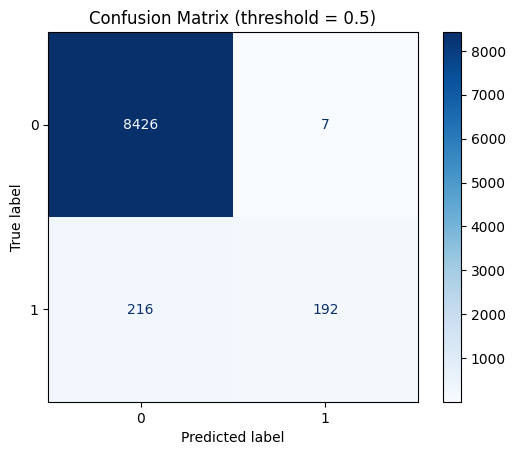

Classification report @ 0.5 threshold:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8433
           1       0.96      0.47      0.63       408

    accuracy                           0.97      8841
   macro avg       0.97      0.73      0.81      8841
weighted avg       0.97      0.97      0.97      8841



In [7]:

# ---------------------------------------------------------
# 4. TRAIN RANDOM FOREST
# ---------------------------------------------------------
model = RandomForestClassifier(
    n_estimators=225,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
model.fit(X_train, y_train)

# ---------------------------------------------------------
# 5. EVALUATE AT DEFAULT THRESHOLD = 0.5
# ---------------------------------------------------------
y_prob = model.predict_proba(X_test)[:, 1]  # illicit probability
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (threshold = 0.5)")
plt.show()

print("Classification report @ 0.5 threshold:")
print(classification_report(y_test, y_pred))

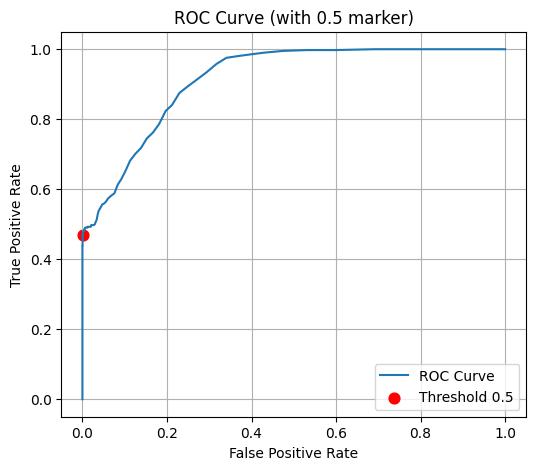

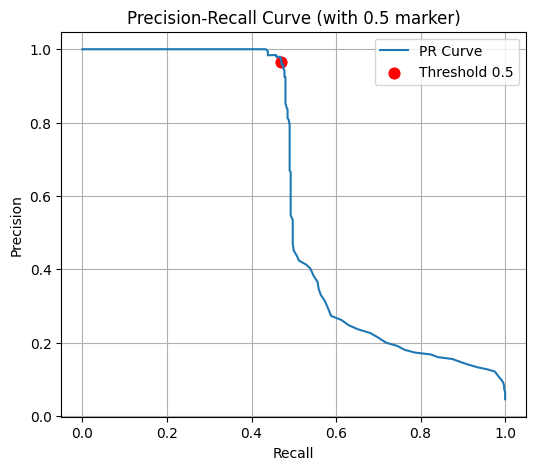

In [9]:
# ---------------------------------------------------------
# 6. ROC CURVE + 0.5 MARKER
# ---------------------------------------------------------
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
idx05 = np.argmin(np.abs(thresholds_roc - 0.5))

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC Curve")
plt.scatter(fpr[idx05], tpr[idx05], s=60, color="red", label="Threshold 0.5")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (with 0.5 marker)")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 7. PR CURVE + 0.5 MARKER
# ---------------------------------------------------------
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)

# PR thresholds are length N-1 relative to precision/recall
idx05_pr = np.argmin(np.abs(thresholds_pr - 0.5))

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label="PR Curve")
plt.scatter(recall[idx05_pr], precision[idx05_pr], s=60, color="red", label="Threshold 0.5")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (with 0.5 marker)")
plt.legend()
plt.grid(True)
plt.show()



Best F1 threshold = 0.4329
Best F1 score     = 0.6350


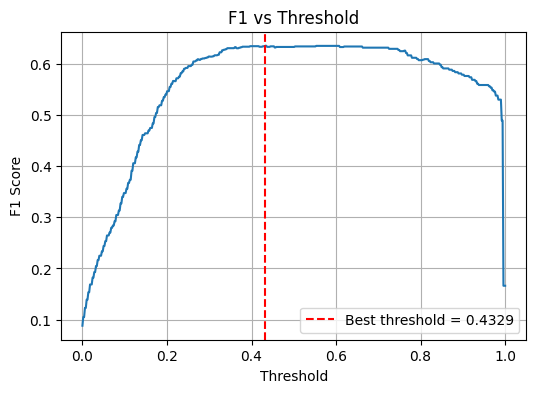

In [11]:
# ---------------------------------------------------------
# 8. FIND BEST THRESHOLD BY F1
# ---------------------------------------------------------
thresholds = np.linspace(0, 1, 500)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t, zero_division=0))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best F1 threshold = {best_threshold:.4f}")
print(f"Best F1 score     = {best_f1:.4f}")

plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores)
plt.axvline(best_threshold, color="red", linestyle="--",
            label=f"Best threshold = {best_threshold:.4f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 500x400 with 0 Axes>

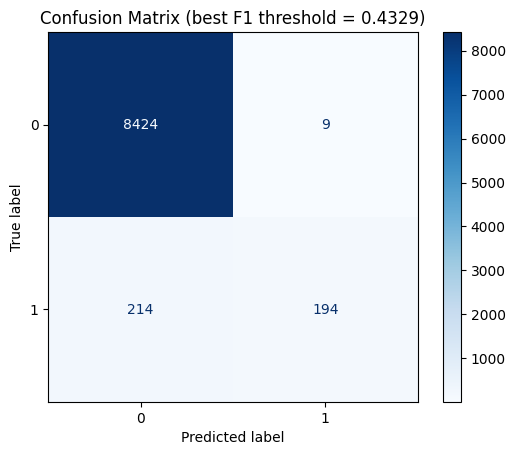

Classification report @ best threshold:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8433
           1       0.96      0.48      0.64       408

    accuracy                           0.97      8841
   macro avg       0.97      0.74      0.81      8841
weighted avg       0.97      0.97      0.97      8841



In [13]:
# ---------------------------------------------------------
# 9. CONFUSION MATRIX AT BEST THRESHOLD
# ---------------------------------------------------------
y_pred_best = (y_prob >= best_threshold).astype(int)
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (best F1 threshold = {best_threshold:.4f})")
plt.show()

print("Classification report @ best threshold:")
print(classification_report(y_test, y_pred_best))